<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:08:44] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


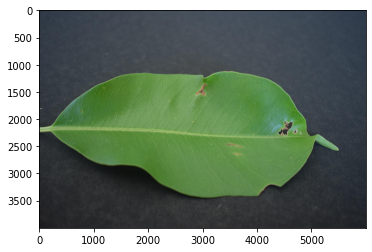

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

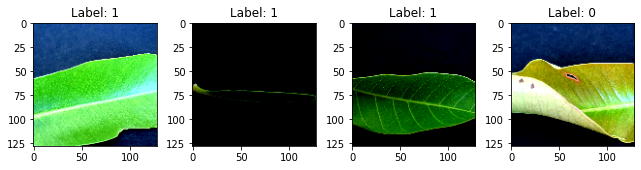

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:08:50] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:08:52] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.256060750122969 samples/sec                   batch loss = 1.0119280815124512 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.26814442858119 samples/sec                   batch loss = 0.6565926671028137 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2342499245570124 samples/sec                   batch loss = 0.36182481050491333 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.272816035652046 samples/sec                   batch loss = 0.7052114605903625 | accuracy = 0.5


Epoch[1] Batch[25] Speed: 1.2208324883232153 samples/sec                   batch loss = 0.5615118741989136 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.2478719063372512 samples/sec                   batch loss = 0.6160555481910706 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.2667030583346357 samples/sec                   batch loss = 0.8798670768737793 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2665291169989241 samples/sec                   batch loss = 0.4712994396686554 | accuracy = 0.54375


Epoch[1] Batch[45] Speed: 1.2803848813196106 samples/sec                   batch loss = 1.3251525163650513 | accuracy = 0.5611111111111111


Epoch[1] Batch[50] Speed: 1.2743792826591092 samples/sec                   batch loss = 0.8745715022087097 | accuracy = 0.56


Epoch[1] Batch[55] Speed: 1.275190890433881 samples/sec                   batch loss = 0.606692910194397 | accuracy = 0.5772727272727273


Epoch[1] Batch[60] Speed: 1.268469462389688 samples/sec                   batch loss = 0.493344783782959 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.2689457123317365 samples/sec                   batch loss = 0.7952833771705627 | accuracy = 0.5769230769230769


Epoch[1] Batch[70] Speed: 1.2721730569848393 samples/sec                   batch loss = 0.5841711759567261 | accuracy = 0.575


Epoch[1] Batch[75] Speed: 1.268831126400786 samples/sec                   batch loss = 0.62266606092453 | accuracy = 0.5766666666666667


Epoch[1] Batch[80] Speed: 1.2618331340614821 samples/sec                   batch loss = 0.7404002547264099 | accuracy = 0.58125


Epoch[1] Batch[85] Speed: 1.2729900662224019 samples/sec                   batch loss = 0.6225213408470154 | accuracy = 0.5852941176470589


Epoch[1] Batch[90] Speed: 1.2691549762232244 samples/sec                   batch loss = 0.4886086881160736 | accuracy = 0.5833333333333334


Epoch[1] Batch[95] Speed: 1.271618332351291 samples/sec                   batch loss = 0.7085387706756592 | accuracy = 0.5842105263157895


Epoch[1] Batch[100] Speed: 1.2655109080928972 samples/sec                   batch loss = 0.9048874378204346 | accuracy = 0.59


Epoch[1] Batch[105] Speed: 1.2689444646347832 samples/sec                   batch loss = 0.5944667458534241 | accuracy = 0.5976190476190476


Epoch[1] Batch[110] Speed: 1.2688389951245205 samples/sec                   batch loss = 0.695702314376831 | accuracy = 0.5954545454545455


Epoch[1] Batch[115] Speed: 1.2682859272496911 samples/sec                   batch loss = 0.924663782119751 | accuracy = 0.5891304347826087


Epoch[1] Batch[120] Speed: 1.2634757780947283 samples/sec                   batch loss = 0.5086140036582947 | accuracy = 0.5958333333333333


Epoch[1] Batch[125] Speed: 1.2691077418282148 samples/sec                   batch loss = 0.5696588754653931 | accuracy = 0.598


Epoch[1] Batch[130] Speed: 1.2680610396832919 samples/sec                   batch loss = 0.6060768365859985 | accuracy = 0.5980769230769231


Epoch[1] Batch[135] Speed: 1.2660734050506601 samples/sec                   batch loss = 0.48047876358032227 | accuracy = 0.5981481481481481


Epoch[1] Batch[140] Speed: 1.266855906038363 samples/sec                   batch loss = 0.3594209849834442 | accuracy = 0.6035714285714285


Epoch[1] Batch[145] Speed: 1.2630304375350017 samples/sec                   batch loss = 0.5835365056991577 | accuracy = 0.6086206896551725


Epoch[1] Batch[150] Speed: 1.2605663015752406 samples/sec                   batch loss = 0.5685709714889526 | accuracy = 0.61


Epoch[1] Batch[155] Speed: 1.2603464153909176 samples/sec                   batch loss = 0.5528529286384583 | accuracy = 0.6096774193548387


Epoch[1] Batch[160] Speed: 1.2632670510055295 samples/sec                   batch loss = 0.7450175881385803 | accuracy = 0.6078125


Epoch[1] Batch[165] Speed: 1.2706666994863094 samples/sec                   batch loss = 0.2634296715259552 | accuracy = 0.6136363636363636


Epoch[1] Batch[170] Speed: 1.267405525037339 samples/sec                   batch loss = 0.633502721786499 | accuracy = 0.6147058823529412


Epoch[1] Batch[175] Speed: 1.2733294757747955 samples/sec                   batch loss = 0.6030022501945496 | accuracy = 0.62


Epoch[1] Batch[180] Speed: 1.2644167618339617 samples/sec                   batch loss = 0.315571665763855 | accuracy = 0.6236111111111111


Epoch[1] Batch[185] Speed: 1.266869394371433 samples/sec                   batch loss = 0.5467579364776611 | accuracy = 0.6243243243243243


Epoch[1] Batch[190] Speed: 1.266152423861651 samples/sec                   batch loss = 0.678296685218811 | accuracy = 0.625


Epoch[1] Batch[195] Speed: 1.2648623178490153 samples/sec                   batch loss = 0.6781295537948608 | accuracy = 0.6269230769230769


Epoch[1] Batch[200] Speed: 1.2716757783181654 samples/sec                   batch loss = 0.4525432884693146 | accuracy = 0.6275


Epoch[1] Batch[205] Speed: 1.2711195610561015 samples/sec                   batch loss = 0.4104492664337158 | accuracy = 0.6304878048780488


Epoch[1] Batch[210] Speed: 1.2645972723733487 samples/sec                   batch loss = 0.7756876945495605 | accuracy = 0.6333333333333333


Epoch[1] Batch[215] Speed: 1.260765704848907 samples/sec                   batch loss = 0.5834099650382996 | accuracy = 0.6337209302325582


Epoch[1] Batch[220] Speed: 1.260390443302843 samples/sec                   batch loss = 0.29893314838409424 | accuracy = 0.6386363636363637


Epoch[1] Batch[225] Speed: 1.2664210851376223 samples/sec                   batch loss = 0.5847356915473938 | accuracy = 0.64


Epoch[1] Batch[230] Speed: 1.2678900788141825 samples/sec                   batch loss = 0.3925168216228485 | accuracy = 0.6445652173913043


Epoch[1] Batch[235] Speed: 1.2651981698488388 samples/sec                   batch loss = 0.5123700499534607 | accuracy = 0.648936170212766


Epoch[1] Batch[240] Speed: 1.2609142799766353 samples/sec                   batch loss = 0.4744487404823303 | accuracy = 0.6510416666666666


Epoch[1] Batch[245] Speed: 1.2739700448902174 samples/sec                   batch loss = 1.268513560295105 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.265561407338668 samples/sec                   batch loss = 0.6367034316062927 | accuracy = 0.653


Epoch[1] Batch[255] Speed: 1.2602720956799898 samples/sec                   batch loss = 0.2520025074481964 | accuracy = 0.6568627450980392


Epoch[1] Batch[260] Speed: 1.2677953227214305 samples/sec                   batch loss = 0.7072733640670776 | accuracy = 0.6596153846153846


Epoch[1] Batch[265] Speed: 1.2751213998444064 samples/sec                   batch loss = 1.0254762172698975 | accuracy = 0.659433962264151


Epoch[1] Batch[270] Speed: 1.277278746871461 samples/sec                   batch loss = 0.4542351961135864 | accuracy = 0.6564814814814814


Epoch[1] Batch[275] Speed: 1.2748909817727208 samples/sec                   batch loss = 0.6002858877182007 | accuracy = 0.6554545454545454


Epoch[1] Batch[280] Speed: 1.2713681752081472 samples/sec                   batch loss = 0.5943206548690796 | accuracy = 0.65625


Epoch[1] Batch[285] Speed: 1.272527570380442 samples/sec                   batch loss = 0.20242296159267426 | accuracy = 0.6587719298245615


Epoch[1] Batch[290] Speed: 1.275712165873143 samples/sec                   batch loss = 0.8727176189422607 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.2705443936596736 samples/sec                   batch loss = 0.6385200023651123 | accuracy = 0.6584745762711864


Epoch[1] Batch[300] Speed: 1.2752440068977977 samples/sec                   batch loss = 0.25462034344673157 | accuracy = 0.66


Epoch[1] Batch[305] Speed: 1.2669134965290023 samples/sec                   batch loss = 0.25325706601142883 | accuracy = 0.6614754098360656


Epoch[1] Batch[310] Speed: 1.2680617105846832 samples/sec                   batch loss = 0.3149315118789673 | accuracy = 0.6637096774193548


Epoch[1] Batch[315] Speed: 1.2671645833531597 samples/sec                   batch loss = 0.6839177012443542 | accuracy = 0.6658730158730158


Epoch[1] Batch[320] Speed: 1.2753545188299182 samples/sec                   batch loss = 0.22327370941638947 | accuracy = 0.66796875


Epoch[1] Batch[325] Speed: 1.2636444083984084 samples/sec                   batch loss = 0.644479513168335 | accuracy = 0.6692307692307692


Epoch[1] Batch[330] Speed: 1.2682356896899971 samples/sec                   batch loss = 0.26660820841789246 | accuracy = 0.6727272727272727


Epoch[1] Batch[335] Speed: 1.2691315505959933 samples/sec                   batch loss = 0.42856791615486145 | accuracy = 0.6746268656716418


Epoch[1] Batch[340] Speed: 1.2767963197811156 samples/sec                   batch loss = 0.3121533691883087 | accuracy = 0.6764705882352942


Epoch[1] Batch[345] Speed: 1.2713959227645066 samples/sec                   batch loss = 1.4933286905288696 | accuracy = 0.6739130434782609


Epoch[1] Batch[350] Speed: 1.266044933942313 samples/sec                   batch loss = 0.2844993472099304 | accuracy = 0.6728571428571428


Epoch[1] Batch[355] Speed: 1.275347732457581 samples/sec                   batch loss = 0.5846724510192871 | accuracy = 0.6697183098591549


Epoch[1] Batch[360] Speed: 1.2689247897380045 samples/sec                   batch loss = 0.4485866129398346 | accuracy = 0.6701388888888888


Epoch[1] Batch[365] Speed: 1.2714683804276572 samples/sec                   batch loss = 0.5703179240226746 | accuracy = 0.6684931506849315


Epoch[1] Batch[370] Speed: 1.2708578555040269 samples/sec                   batch loss = 0.426154226064682 | accuracy = 0.6702702702702703


Epoch[1] Batch[375] Speed: 1.2734905968082912 samples/sec                   batch loss = 0.802669882774353 | accuracy = 0.6713333333333333


Epoch[1] Batch[380] Speed: 1.2697120696093254 samples/sec                   batch loss = 0.8290160894393921 | accuracy = 0.6717105263157894


Epoch[1] Batch[385] Speed: 1.2722661531055575 samples/sec                   batch loss = 0.4451026916503906 | accuracy = 0.6727272727272727


Epoch[1] Batch[390] Speed: 1.2711340071057424 samples/sec                   batch loss = 0.5534946322441101 | accuracy = 0.6737179487179488


Epoch[1] Batch[395] Speed: 1.2741384885723923 samples/sec                   batch loss = 0.7109373211860657 | accuracy = 0.6765822784810127


Epoch[1] Batch[400] Speed: 1.2758998944432107 samples/sec                   batch loss = 0.4956667423248291 | accuracy = 0.67625


Epoch[1] Batch[405] Speed: 1.2642887011332182 samples/sec                   batch loss = 0.36030876636505127 | accuracy = 0.6759259259259259


Epoch[1] Batch[410] Speed: 1.2711056931573543 samples/sec                   batch loss = 0.5569322109222412 | accuracy = 0.676829268292683


Epoch[1] Batch[415] Speed: 1.2692020221032125 samples/sec                   batch loss = 0.6837396025657654 | accuracy = 0.6734939759036145


Epoch[1] Batch[420] Speed: 1.2729745154951562 samples/sec                   batch loss = 0.4632446765899658 | accuracy = 0.6726190476190477


Epoch[1] Batch[425] Speed: 1.2790070209163784 samples/sec                   batch loss = 1.4456676244735718 | accuracy = 0.6747058823529412


Epoch[1] Batch[430] Speed: 1.2735525624212627 samples/sec                   batch loss = 0.4296359121799469 | accuracy = 0.6779069767441861


Epoch[1] Batch[435] Speed: 1.2781953214554707 samples/sec                   batch loss = 0.45449453592300415 | accuracy = 0.6775862068965517


Epoch[1] Batch[440] Speed: 1.2724467887912663 samples/sec                   batch loss = 0.14881114661693573 | accuracy = 0.678409090909091


Epoch[1] Batch[445] Speed: 1.272987458309951 samples/sec                   batch loss = 0.5550743937492371 | accuracy = 0.6797752808988764


Epoch[1] Batch[450] Speed: 1.269646345573958 samples/sec                   batch loss = 0.49162644147872925 | accuracy = 0.68


Epoch[1] Batch[455] Speed: 1.2744123892831936 samples/sec                   batch loss = 0.3030478060245514 | accuracy = 0.6813186813186813


Epoch[1] Batch[460] Speed: 1.2717952169987339 samples/sec                   batch loss = 0.48708978295326233 | accuracy = 0.6804347826086956


Epoch[1] Batch[465] Speed: 1.2837392117022988 samples/sec                   batch loss = 0.6242287755012512 | accuracy = 0.6817204301075269


Epoch[1] Batch[470] Speed: 1.2677744380458313 samples/sec                   batch loss = 1.096506953239441 | accuracy = 0.6803191489361702


Epoch[1] Batch[475] Speed: 1.2658672573015426 samples/sec                   batch loss = 0.28311675786972046 | accuracy = 0.6815789473684211


Epoch[1] Batch[480] Speed: 1.2728332241231148 samples/sec                   batch loss = 0.957167387008667 | accuracy = 0.68125


Epoch[1] Batch[485] Speed: 1.2740633074567473 samples/sec                   batch loss = 0.24741138517856598 | accuracy = 0.681958762886598


Epoch[1] Batch[490] Speed: 1.268445966160139 samples/sec                   batch loss = 0.8570759296417236 | accuracy = 0.6821428571428572


Epoch[1] Batch[495] Speed: 1.272542917146288 samples/sec                   batch loss = 0.46804437041282654 | accuracy = 0.6833333333333333


Epoch[1] Batch[500] Speed: 1.2728592974092257 samples/sec                   batch loss = 0.5621014833450317 | accuracy = 0.6835


Epoch[1] Batch[505] Speed: 1.2704398124677179 samples/sec                   batch loss = 0.5082647204399109 | accuracy = 0.6826732673267327


Epoch[1] Batch[510] Speed: 1.2687388201251435 samples/sec                   batch loss = 0.5056571364402771 | accuracy = 0.682843137254902


Epoch[1] Batch[515] Speed: 1.2640985636086102 samples/sec                   batch loss = 0.4709949791431427 | accuracy = 0.683495145631068


Epoch[1] Batch[520] Speed: 1.2754157933471393 samples/sec                   batch loss = 0.41532838344573975 | accuracy = 0.6841346153846154


Epoch[1] Batch[525] Speed: 1.264849730443539 samples/sec                   batch loss = 0.6578918099403381 | accuracy = 0.6852380952380952


Epoch[1] Batch[530] Speed: 1.268320635674693 samples/sec                   batch loss = 0.14273755252361298 | accuracy = 0.6867924528301886


Epoch[1] Batch[535] Speed: 1.2781828567998041 samples/sec                   batch loss = 0.465416818857193 | accuracy = 0.6873831775700935


Epoch[1] Batch[540] Speed: 1.27177015133165 samples/sec                   batch loss = 0.7775589227676392 | accuracy = 0.687962962962963


Epoch[1] Batch[545] Speed: 1.2730877257468793 samples/sec                   batch loss = 0.4671285152435303 | accuracy = 0.6885321100917431


Epoch[1] Batch[550] Speed: 1.270851983289841 samples/sec                   batch loss = 0.5237468481063843 | accuracy = 0.6895454545454546


Epoch[1] Batch[555] Speed: 1.2613512064931722 samples/sec                   batch loss = 0.7318077087402344 | accuracy = 0.6896396396396396


Epoch[1] Batch[560] Speed: 1.267296673526916 samples/sec                   batch loss = 0.3562593460083008 | accuracy = 0.6888392857142858


Epoch[1] Batch[565] Speed: 1.260505687905154 samples/sec                   batch loss = 0.7697909474372864 | accuracy = 0.6884955752212389


Epoch[1] Batch[570] Speed: 1.284487454607692 samples/sec                   batch loss = 0.6182177662849426 | accuracy = 0.6890350877192982


Epoch[1] Batch[575] Speed: 1.2998975405390496 samples/sec                   batch loss = 0.27695488929748535 | accuracy = 0.6908695652173913


Epoch[1] Batch[580] Speed: 1.2953963717477974 samples/sec                   batch loss = 0.3217623233795166 | accuracy = 0.6913793103448276


Epoch[1] Batch[585] Speed: 1.2858700588203058 samples/sec                   batch loss = 0.5748654007911682 | accuracy = 0.6918803418803419


Epoch[1] Batch[590] Speed: 1.2861597742974662 samples/sec                   batch loss = 3.0706164836883545 | accuracy = 0.6911016949152542


Epoch[1] Batch[595] Speed: 1.2944528736723002 samples/sec                   batch loss = 0.26225966215133667 | accuracy = 0.6928571428571428


Epoch[1] Batch[600] Speed: 1.297178269601776 samples/sec                   batch loss = 0.7434443235397339 | accuracy = 0.6941666666666667


Epoch[1] Batch[605] Speed: 1.3030476958868586 samples/sec                   batch loss = 0.6902104616165161 | accuracy = 0.693801652892562


Epoch[1] Batch[610] Speed: 1.3006482070597225 samples/sec                   batch loss = 0.31117695569992065 | accuracy = 0.6950819672131148


Epoch[1] Batch[615] Speed: 1.2947946329497029 samples/sec                   batch loss = 0.6932676434516907 | accuracy = 0.6947154471544715


Epoch[1] Batch[620] Speed: 1.294571035439786 samples/sec                   batch loss = 0.2839709520339966 | accuracy = 0.6939516129032258


Epoch[1] Batch[625] Speed: 1.294577029003646 samples/sec                   batch loss = 0.7574237585067749 | accuracy = 0.6936


Epoch[1] Batch[630] Speed: 1.2928030625560831 samples/sec                   batch loss = 0.3443509042263031 | accuracy = 0.6932539682539682


Epoch[1] Batch[635] Speed: 1.2923072467331476 samples/sec                   batch loss = 0.7629001140594482 | accuracy = 0.6933070866141732


Epoch[1] Batch[640] Speed: 1.2965521291944972 samples/sec                   batch loss = 0.29959654808044434 | accuracy = 0.69375


Epoch[1] Batch[645] Speed: 1.2994428662999946 samples/sec                   batch loss = 0.468636155128479 | accuracy = 0.6934108527131783


Epoch[1] Batch[650] Speed: 1.3013567382681606 samples/sec                   batch loss = 0.36235707998275757 | accuracy = 0.6923076923076923


Epoch[1] Batch[655] Speed: 1.30031141348239 samples/sec                   batch loss = 0.8866520524024963 | accuracy = 0.6919847328244275


Epoch[1] Batch[660] Speed: 1.2956975009663352 samples/sec                   batch loss = 0.7230795621871948 | accuracy = 0.6909090909090909


Epoch[1] Batch[665] Speed: 1.2993190840929054 samples/sec                   batch loss = 0.2611818313598633 | accuracy = 0.6909774436090226


Epoch[1] Batch[670] Speed: 1.2986481523122753 samples/sec                   batch loss = 0.4278627038002014 | accuracy = 0.6917910447761194


Epoch[1] Batch[675] Speed: 1.3004908268401356 samples/sec                   batch loss = 0.7131645083427429 | accuracy = 0.6911111111111111


Epoch[1] Batch[680] Speed: 1.3039481287609855 samples/sec                   batch loss = 0.24969041347503662 | accuracy = 0.6897058823529412


Epoch[1] Batch[685] Speed: 1.2964811927257036 samples/sec                   batch loss = 0.6592844128608704 | accuracy = 0.6897810218978102


Epoch[1] Batch[690] Speed: 1.2957585442154436 samples/sec                   batch loss = 0.69129478931427 | accuracy = 0.6909420289855073


Epoch[1] Batch[695] Speed: 1.2965824899704912 samples/sec                   batch loss = 0.6550105810165405 | accuracy = 0.6913669064748201


Epoch[1] Batch[700] Speed: 1.2972943213386896 samples/sec                   batch loss = 0.5455482006072998 | accuracy = 0.6921428571428572


Epoch[1] Batch[705] Speed: 1.3036409242405322 samples/sec                   batch loss = 0.19279107451438904 | accuracy = 0.6929078014184397


Epoch[1] Batch[710] Speed: 1.3017306346881259 samples/sec                   batch loss = 0.24116012454032898 | accuracy = 0.6936619718309859


Epoch[1] Batch[715] Speed: 1.2951864644605318 samples/sec                   batch loss = 0.3100319802761078 | accuracy = 0.6923076923076923


Epoch[1] Batch[720] Speed: 1.29991355457587 samples/sec                   batch loss = 0.7470266819000244 | accuracy = 0.6927083333333334


Epoch[1] Batch[725] Speed: 1.2947180935623774 samples/sec                   batch loss = 0.3758211135864258 | accuracy = 0.6941379310344827


Epoch[1] Batch[730] Speed: 1.2970842999619392 samples/sec                   batch loss = 0.2698054313659668 | accuracy = 0.6941780821917808


Epoch[1] Batch[735] Speed: 1.2968974040355044 samples/sec                   batch loss = 0.7345885038375854 | accuracy = 0.6952380952380952


Epoch[1] Batch[740] Speed: 1.2963029840700577 samples/sec                   batch loss = 0.5549289584159851 | accuracy = 0.6959459459459459


Epoch[1] Batch[745] Speed: 1.29591438068727 samples/sec                   batch loss = 0.7738503813743591 | accuracy = 0.6966442953020134


Epoch[1] Batch[750] Speed: 1.2916892794711665 samples/sec                   batch loss = 0.2583359181880951 | accuracy = 0.6973333333333334


Epoch[1] Batch[755] Speed: 1.295759645048141 samples/sec                   batch loss = 0.545515775680542 | accuracy = 0.6966887417218544


Epoch[1] Batch[760] Speed: 1.297421731337014 samples/sec                   batch loss = 0.2518869638442993 | accuracy = 0.6967105263157894


Epoch[1] Batch[765] Speed: 1.2888729985159368 samples/sec                   batch loss = 0.2682170569896698 | accuracy = 0.6964052287581699


Epoch[1] Batch[770] Speed: 1.296339042575887 samples/sec                   batch loss = 0.4412113130092621 | accuracy = 0.6967532467532468


Epoch[1] Batch[775] Speed: 1.2991069983619863 samples/sec                   batch loss = 0.6656863689422607 | accuracy = 0.6967741935483871


Epoch[1] Batch[780] Speed: 1.295240259844533 samples/sec                   batch loss = 0.22709409892559052 | accuracy = 0.6974358974358974


Epoch[1] Batch[785] Speed: 1.2955823350236872 samples/sec                   batch loss = 0.37985894083976746 | accuracy = 0.697452229299363


[Epoch 1] training: accuracy=0.6973350253807107
[Epoch 1] time cost: 639.959014415741
[Epoch 1] validation: validation accuracy=0.7833333333333333


Epoch[2] Batch[5] Speed: 1.2922572779713832 samples/sec                   batch loss = 0.30498769879341125 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.3006081778572158 samples/sec                   batch loss = 0.5049751996994019 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.3009564236775208 samples/sec                   batch loss = 0.7065696120262146 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2954044733924706 samples/sec                   batch loss = 0.41005218029022217 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.29446915334459 samples/sec                   batch loss = 0.4748254716396332 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.3083646370054285 samples/sec                   batch loss = 0.6801246404647827 | accuracy = 0.725


Epoch[2] Batch[35] Speed: 1.3005683527584027 samples/sec                   batch loss = 0.6178867220878601 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.2994588691360225 samples/sec                   batch loss = 0.2742038667201996 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2985665332048173 samples/sec                   batch loss = 0.3599238097667694 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2986522737462134 samples/sec                   batch loss = 0.4465091824531555 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.3033927941182526 samples/sec                   batch loss = 0.6056126952171326 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2959332998044422 samples/sec                   batch loss = 0.42406579852104187 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.296900612094886 samples/sec                   batch loss = 0.7955814599990845 | accuracy = 0.7269230769230769


Epoch[2] Batch[70] Speed: 1.300604447301391 samples/sec                   batch loss = 0.2521558701992035 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2964434232249475 samples/sec                   batch loss = 0.6200850009918213 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.300958441283113 samples/sec                   batch loss = 1.0129427909851074 | accuracy = 0.721875


Epoch[2] Batch[85] Speed: 1.297314484561329 samples/sec                   batch loss = 0.6358998417854309 | accuracy = 0.7176470588235294


Epoch[2] Batch[90] Speed: 1.3029419455467832 samples/sec                   batch loss = 0.19504016637802124 | accuracy = 0.7222222222222222


Epoch[2] Batch[95] Speed: 1.3028673740489742 samples/sec                   batch loss = 0.7135219573974609 | accuracy = 0.7263157894736842


Epoch[2] Batch[100] Speed: 1.2949873204489273 samples/sec                   batch loss = 0.789294958114624 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.291815292426042 samples/sec                   batch loss = 0.3780384659767151 | accuracy = 0.7238095238095238


Epoch[2] Batch[110] Speed: 1.289199335068483 samples/sec                   batch loss = 0.43641799688339233 | accuracy = 0.7272727272727273


Epoch[2] Batch[115] Speed: 1.2968518914028646 samples/sec                   batch loss = 0.42678138613700867 | accuracy = 0.7239130434782609


Epoch[2] Batch[120] Speed: 1.2969751036863242 samples/sec                   batch loss = 0.2929441034793854 | accuracy = 0.7270833333333333


Epoch[2] Batch[125] Speed: 1.294998615634431 samples/sec                   batch loss = 0.9540473818778992 | accuracy = 0.726


Epoch[2] Batch[130] Speed: 1.2965239741020023 samples/sec                   batch loss = 0.5508590936660767 | accuracy = 0.725


Epoch[2] Batch[135] Speed: 1.2956981013637285 samples/sec                   batch loss = 0.4200047254562378 | accuracy = 0.7277777777777777


Epoch[2] Batch[140] Speed: 1.291315562457398 samples/sec                   batch loss = 0.7683722376823425 | accuracy = 0.7321428571428571


Epoch[2] Batch[145] Speed: 1.2928577560371757 samples/sec                   batch loss = 0.707438588142395 | accuracy = 0.7327586206896551


Epoch[2] Batch[150] Speed: 1.296511049219955 samples/sec                   batch loss = 0.267605721950531 | accuracy = 0.7283333333333334


Epoch[2] Batch[155] Speed: 1.291979633543632 samples/sec                   batch loss = 0.7495063543319702 | accuracy = 0.7290322580645161


Epoch[2] Batch[160] Speed: 1.295520508064216 samples/sec                   batch loss = 0.45076891779899597 | accuracy = 0.7359375


Epoch[2] Batch[165] Speed: 1.2954463835180758 samples/sec                   batch loss = 0.6710390448570251 | accuracy = 0.7363636363636363


Epoch[2] Batch[170] Speed: 1.3014229597314186 samples/sec                   batch loss = 0.854155421257019 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.2998894833112362 samples/sec                   batch loss = 0.6928918361663818 | accuracy = 0.73


Epoch[2] Batch[180] Speed: 1.299451320579351 samples/sec                   batch loss = 0.5621157288551331 | accuracy = 0.7305555555555555


Epoch[2] Batch[185] Speed: 1.2979417633399184 samples/sec                   batch loss = 0.3267202079296112 | accuracy = 0.7337837837837838


Epoch[2] Batch[190] Speed: 1.2978254953480166 samples/sec                   batch loss = 0.46971362829208374 | accuracy = 0.7328947368421053


Epoch[2] Batch[195] Speed: 1.301155793349308 samples/sec                   batch loss = 0.2134990394115448 | accuracy = 0.732051282051282


Epoch[2] Batch[200] Speed: 1.2968022722385548 samples/sec                   batch loss = 0.8815712928771973 | accuracy = 0.735


Epoch[2] Batch[205] Speed: 1.2970277442235774 samples/sec                   batch loss = 0.5069189071655273 | accuracy = 0.7353658536585366


Epoch[2] Batch[210] Speed: 1.3015942986605706 samples/sec                   batch loss = 0.46352407336235046 | accuracy = 0.7380952380952381


Epoch[2] Batch[215] Speed: 1.2981443282377227 samples/sec                   batch loss = 0.2852148413658142 | accuracy = 0.7406976744186047


Epoch[2] Batch[220] Speed: 1.3046562025933839 samples/sec                   batch loss = 0.3779051899909973 | accuracy = 0.7443181818181818


Epoch[2] Batch[225] Speed: 1.2990605258243124 samples/sec                   batch loss = 0.5220302939414978 | accuracy = 0.7444444444444445


Epoch[2] Batch[230] Speed: 1.3022872828785852 samples/sec                   batch loss = 0.19893388450145721 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.300784647511825 samples/sec                   batch loss = 0.4739839434623718 | accuracy = 0.75


Epoch[2] Batch[240] Speed: 1.301930645867085 samples/sec                   batch loss = 0.6568359732627869 | accuracy = 0.753125


Epoch[2] Batch[245] Speed: 1.2990854717082232 samples/sec                   batch loss = 0.19244863092899323 | accuracy = 0.7561224489795918


Epoch[2] Batch[250] Speed: 1.3008438512018792 samples/sec                   batch loss = 0.28765344619750977 | accuracy = 0.759


Epoch[2] Batch[255] Speed: 1.300475100993455 samples/sec                   batch loss = 0.30272313952445984 | accuracy = 0.7617647058823529


Epoch[2] Batch[260] Speed: 1.2934129225220403 samples/sec                   batch loss = 0.5452277064323425 | accuracy = 0.7615384615384615


Epoch[2] Batch[265] Speed: 1.298419403493204 samples/sec                   batch loss = 0.49702346324920654 | accuracy = 0.7622641509433963


Epoch[2] Batch[270] Speed: 1.2981610022351728 samples/sec                   batch loss = 0.31897681951522827 | accuracy = 0.7620370370370371


Epoch[2] Batch[275] Speed: 1.2969341974193376 samples/sec                   batch loss = 0.30702468752861023 | accuracy = 0.7654545454545455


Epoch[2] Batch[280] Speed: 1.298583821124839 samples/sec                   batch loss = 0.19018511474132538 | accuracy = 0.7633928571428571


Epoch[2] Batch[285] Speed: 1.2957520393331408 samples/sec                   batch loss = 0.14538080990314484 | accuracy = 0.7649122807017544


Epoch[2] Batch[290] Speed: 1.2936623543858228 samples/sec                   batch loss = 0.5091185569763184 | accuracy = 0.7655172413793103


Epoch[2] Batch[295] Speed: 1.2991305376691125 samples/sec                   batch loss = 0.6518219113349915 | accuracy = 0.7627118644067796


Epoch[2] Batch[300] Speed: 1.2995264074587534 samples/sec                   batch loss = 0.5402374267578125 | accuracy = 0.7625


Epoch[2] Batch[305] Speed: 1.3016418615419088 samples/sec                   batch loss = 0.6850171685218811 | accuracy = 0.760655737704918


Epoch[2] Batch[310] Speed: 1.2897613776137762 samples/sec                   batch loss = 0.6384047865867615 | accuracy = 0.7596774193548387


Epoch[2] Batch[315] Speed: 1.2983153072553586 samples/sec                   batch loss = 0.3094048798084259 | accuracy = 0.7611111111111111


Epoch[2] Batch[320] Speed: 1.2972698454330265 samples/sec                   batch loss = 0.3832602798938751 | accuracy = 0.76328125


Epoch[2] Batch[325] Speed: 1.2905962767272956 samples/sec                   batch loss = 0.6124604940414429 | accuracy = 0.7623076923076924


Epoch[2] Batch[330] Speed: 1.289115135316928 samples/sec                   batch loss = 0.6615631580352783 | accuracy = 0.7613636363636364


Epoch[2] Batch[335] Speed: 1.292637217179056 samples/sec                   batch loss = 0.6460206508636475 | accuracy = 0.7619402985074627


Epoch[2] Batch[340] Speed: 1.2912547383366804 samples/sec                   batch loss = 0.7851198315620422 | accuracy = 0.7625


Epoch[2] Batch[345] Speed: 1.2910039490653673 samples/sec                   batch loss = 0.2914787828922272 | accuracy = 0.7630434782608696


Epoch[2] Batch[350] Speed: 1.2947916351532984 samples/sec                   batch loss = 0.5019358396530151 | accuracy = 0.7614285714285715


Epoch[2] Batch[355] Speed: 1.3047732918515598 samples/sec                   batch loss = 1.2356396913528442 | accuracy = 0.7612676056338028


Epoch[2] Batch[360] Speed: 1.2942715278355827 samples/sec                   batch loss = 0.2120397835969925 | accuracy = 0.7618055555555555


Epoch[2] Batch[365] Speed: 1.3058449136683938 samples/sec                   batch loss = 0.47751325368881226 | accuracy = 0.760958904109589


Epoch[2] Batch[370] Speed: 1.3054670250682703 samples/sec                   batch loss = 0.7907398343086243 | accuracy = 0.7601351351351351


Epoch[2] Batch[375] Speed: 1.3000142808337187 samples/sec                   batch loss = 0.31635576486587524 | accuracy = 0.76


Epoch[2] Batch[380] Speed: 1.3043737123683465 samples/sec                   batch loss = 0.2585085928440094 | accuracy = 0.7611842105263158


Epoch[2] Batch[385] Speed: 1.3032743326466056 samples/sec                   batch loss = 0.4258003830909729 | accuracy = 0.7623376623376623


Epoch[2] Batch[390] Speed: 1.304015526422355 samples/sec                   batch loss = 0.356364905834198 | accuracy = 0.7634615384615384


Epoch[2] Batch[395] Speed: 1.294733980236673 samples/sec                   batch loss = 0.27160748839378357 | accuracy = 0.7626582278481012


Epoch[2] Batch[400] Speed: 1.2962345785843201 samples/sec                   batch loss = 0.35083091259002686 | accuracy = 0.76375


Epoch[2] Batch[405] Speed: 1.2988448040180138 samples/sec                   batch loss = 0.5676743388175964 | accuracy = 0.7635802469135803


Epoch[2] Batch[410] Speed: 1.3023836255604846 samples/sec                   batch loss = 0.421695351600647 | accuracy = 0.7628048780487805


Epoch[2] Batch[415] Speed: 1.2911589420282716 samples/sec                   batch loss = 0.5807088017463684 | accuracy = 0.7620481927710844


Epoch[2] Batch[420] Speed: 1.2927151044229443 samples/sec                   batch loss = 0.22429822385311127 | accuracy = 0.7625


Epoch[2] Batch[425] Speed: 1.2989875042680912 samples/sec                   batch loss = 0.5678339600563049 | accuracy = 0.7623529411764706


Epoch[2] Batch[430] Speed: 1.2965441133852913 samples/sec                   batch loss = 0.7472591996192932 | accuracy = 0.7622093023255814


Epoch[2] Batch[435] Speed: 1.3018892243650744 samples/sec                   batch loss = 0.3885546028614044 | accuracy = 0.7632183908045977


Epoch[2] Batch[440] Speed: 1.296501931822511 samples/sec                   batch loss = 0.32606691122055054 | accuracy = 0.7636363636363637


Epoch[2] Batch[445] Speed: 1.306260345539058 samples/sec                   batch loss = 0.650634229183197 | accuracy = 0.7601123595505618


Epoch[2] Batch[450] Speed: 1.2926666976917063 samples/sec                   batch loss = 0.6964805126190186 | accuracy = 0.7588888888888888


Epoch[2] Batch[455] Speed: 1.2953731675979125 samples/sec                   batch loss = 0.8449625968933105 | accuracy = 0.7565934065934066


Epoch[2] Batch[460] Speed: 1.2968161050783955 samples/sec                   batch loss = 0.28955933451652527 | accuracy = 0.7581521739130435


Epoch[2] Batch[465] Speed: 1.2933023495679477 samples/sec                   batch loss = 0.4885384440422058 | accuracy = 0.7586021505376344


Epoch[2] Batch[470] Speed: 1.2935306950334597 samples/sec                   batch loss = 0.22466842830181122 | accuracy = 0.7585106382978724


Epoch[2] Batch[475] Speed: 1.2954482840415058 samples/sec                   batch loss = 0.8246934413909912 | accuracy = 0.7573684210526316


Epoch[2] Batch[480] Speed: 1.2939402236157824 samples/sec                   batch loss = 0.16847997903823853 | accuracy = 0.75625


Epoch[2] Batch[485] Speed: 1.2941707910099602 samples/sec                   batch loss = 0.6132906675338745 | accuracy = 0.7561855670103093


Epoch[2] Batch[490] Speed: 1.2957625472524001 samples/sec                   batch loss = 0.991740345954895 | accuracy = 0.7556122448979592


Epoch[2] Batch[495] Speed: 1.2899930368799317 samples/sec                   batch loss = 0.4431103467941284 | accuracy = 0.7560606060606061


Epoch[2] Batch[500] Speed: 1.2946869208439982 samples/sec                   batch loss = 0.7952199578285217 | accuracy = 0.755


Epoch[2] Batch[505] Speed: 1.297705935746709 samples/sec                   batch loss = 0.8991603851318359 | accuracy = 0.754950495049505


Epoch[2] Batch[510] Speed: 1.2927461822599935 samples/sec                   batch loss = 0.5352453589439392 | accuracy = 0.7544117647058823


Epoch[2] Batch[515] Speed: 1.2957019038934734 samples/sec                   batch loss = 0.25036078691482544 | accuracy = 0.7533980582524272


Epoch[2] Batch[520] Speed: 1.2944160212029359 samples/sec                   batch loss = 0.6018606424331665 | accuracy = 0.7524038461538461


Epoch[2] Batch[525] Speed: 1.292914945062804 samples/sec                   batch loss = 1.0277940034866333 | accuracy = 0.7509523809523809


Epoch[2] Batch[530] Speed: 1.2937822675068034 samples/sec                   batch loss = 0.4932281970977783 | accuracy = 0.7514150943396226


Epoch[2] Batch[535] Speed: 1.2901336001999961 samples/sec                   batch loss = 0.5578043460845947 | accuracy = 0.7514018691588785


Epoch[2] Batch[540] Speed: 1.2984680410473766 samples/sec                   batch loss = 0.4123871624469757 | accuracy = 0.7518518518518519


Epoch[2] Batch[545] Speed: 1.2934403443496767 samples/sec                   batch loss = 0.4056526720523834 | accuracy = 0.7532110091743119


Epoch[2] Batch[550] Speed: 1.2959783475449842 samples/sec                   batch loss = 0.4489290118217468 | accuracy = 0.7531818181818182


Epoch[2] Batch[555] Speed: 1.2973745766883729 samples/sec                   batch loss = 0.693871021270752 | accuracy = 0.7527027027027027


Epoch[2] Batch[560] Speed: 1.2976658867003836 samples/sec                   batch loss = 0.30604979395866394 | accuracy = 0.7544642857142857


Epoch[2] Batch[565] Speed: 1.296231774413918 samples/sec                   batch loss = 0.65556800365448 | accuracy = 0.754424778761062


Epoch[2] Batch[570] Speed: 1.2943101694115018 samples/sec                   batch loss = 0.37392276525497437 | accuracy = 0.7548245614035087


Epoch[2] Batch[575] Speed: 1.3008733037670253 samples/sec                   batch loss = 1.0099027156829834 | accuracy = 0.7534782608695653


Epoch[2] Batch[580] Speed: 1.2973621364589019 samples/sec                   batch loss = 0.41979068517684937 | accuracy = 0.7530172413793104


Epoch[2] Batch[585] Speed: 1.2944127255558624 samples/sec                   batch loss = 0.6401856541633606 | accuracy = 0.7525641025641026


Epoch[2] Batch[590] Speed: 1.2996376445883457 samples/sec                   batch loss = 0.7284734845161438 | accuracy = 0.7533898305084745


Epoch[2] Batch[595] Speed: 1.3040102559781848 samples/sec                   batch loss = 0.9732033610343933 | accuracy = 0.7521008403361344


Epoch[2] Batch[600] Speed: 1.2985840221498723 samples/sec                   batch loss = 0.38066667318344116 | accuracy = 0.7533333333333333


Epoch[2] Batch[605] Speed: 1.3012676123958629 samples/sec                   batch loss = 1.5798919200897217 | accuracy = 0.7541322314049587


Epoch[2] Batch[610] Speed: 1.3016471128586524 samples/sec                   batch loss = 0.5024654269218445 | accuracy = 0.7540983606557377


Epoch[2] Batch[615] Speed: 1.303548953161184 samples/sec                   batch loss = 0.3772592842578888 | accuracy = 0.7544715447154472


Epoch[2] Batch[620] Speed: 1.3017764904070388 samples/sec                   batch loss = 0.11883869767189026 | accuracy = 0.7548387096774194


Epoch[2] Batch[625] Speed: 1.3020712965853918 samples/sec                   batch loss = 0.4358145594596863 | accuracy = 0.754


Epoch[2] Batch[630] Speed: 1.295340763193494 samples/sec                   batch loss = 0.7891321778297424 | accuracy = 0.7523809523809524


Epoch[2] Batch[635] Speed: 1.2974009628034202 samples/sec                   batch loss = 0.551837682723999 | accuracy = 0.7523622047244094


Epoch[2] Batch[640] Speed: 1.3051007256879599 samples/sec                   batch loss = 0.7076860666275024 | accuracy = 0.75234375


Epoch[2] Batch[645] Speed: 1.2947706509671413 samples/sec                   batch loss = 0.19858157634735107 | accuracy = 0.7523255813953489


Epoch[2] Batch[650] Speed: 1.2991778200515143 samples/sec                   batch loss = 0.5651176571846008 | accuracy = 0.7534615384615385


Epoch[2] Batch[655] Speed: 1.3033911739870803 samples/sec                   batch loss = 0.4243170917034149 | accuracy = 0.7530534351145038


Epoch[2] Batch[660] Speed: 1.3023076016075223 samples/sec                   batch loss = 0.8313627243041992 | accuracy = 0.7522727272727273


Epoch[2] Batch[665] Speed: 1.299979327053758 samples/sec                   batch loss = 0.40500515699386597 | accuracy = 0.7522556390977444


Epoch[2] Batch[670] Speed: 1.3073736341893012 samples/sec                   batch loss = 0.540889322757721 | accuracy = 0.7533582089552239


Epoch[2] Batch[675] Speed: 1.3018275011146516 samples/sec                   batch loss = 0.6756096482276917 | accuracy = 0.7533333333333333


Epoch[2] Batch[680] Speed: 1.3092500599522208 samples/sec                   batch loss = 0.49931877851486206 | accuracy = 0.7540441176470588


Epoch[2] Batch[685] Speed: 1.3010966621642905 samples/sec                   batch loss = 0.3167235851287842 | accuracy = 0.7536496350364964


Epoch[2] Batch[690] Speed: 1.2918496096049479 samples/sec                   batch loss = 0.23295119404792786 | accuracy = 0.7543478260869565


Epoch[2] Batch[695] Speed: 1.290764478637342 samples/sec                   batch loss = 0.4249271750450134 | accuracy = 0.7550359712230216


Epoch[2] Batch[700] Speed: 1.295248759524032 samples/sec                   batch loss = 0.11657552421092987 | accuracy = 0.7560714285714286


Epoch[2] Batch[705] Speed: 1.29231859475931 samples/sec                   batch loss = 0.1343282014131546 | accuracy = 0.7560283687943262


Epoch[2] Batch[710] Speed: 1.296810792431088 samples/sec                   batch loss = 0.360135018825531 | accuracy = 0.7566901408450705


Epoch[2] Batch[715] Speed: 1.2992060905241571 samples/sec                   batch loss = 0.5057142376899719 | accuracy = 0.7573426573426574


Epoch[2] Batch[720] Speed: 1.2993865072488058 samples/sec                   batch loss = 0.5023565292358398 | accuracy = 0.7572916666666667


Epoch[2] Batch[725] Speed: 1.3087477784454349 samples/sec                   batch loss = 0.33184486627578735 | accuracy = 0.7582758620689655


Epoch[2] Batch[730] Speed: 1.3008498021263661 samples/sec                   batch loss = 0.1479620486497879 | accuracy = 0.7585616438356164


Epoch[2] Batch[735] Speed: 1.3012249210875455 samples/sec                   batch loss = 0.7739191651344299 | accuracy = 0.7581632653061224


Epoch[2] Batch[740] Speed: 1.2986255351526912 samples/sec                   batch loss = 0.10085798799991608 | accuracy = 0.7581081081081081


Epoch[2] Batch[745] Speed: 1.2958030793946251 samples/sec                   batch loss = 0.7036868929862976 | accuracy = 0.7583892617449665


Epoch[2] Batch[750] Speed: 1.2991576994681242 samples/sec                   batch loss = 0.619608461856842 | accuracy = 0.7583333333333333


Epoch[2] Batch[755] Speed: 1.2974770170028629 samples/sec                   batch loss = 0.6235966086387634 | accuracy = 0.759271523178808


Epoch[2] Batch[760] Speed: 1.2937688983873556 samples/sec                   batch loss = 0.6553561091423035 | accuracy = 0.7595394736842105


Epoch[2] Batch[765] Speed: 1.2910367329349797 samples/sec                   batch loss = 0.5128331780433655 | accuracy = 0.7591503267973856


Epoch[2] Batch[770] Speed: 1.2963208127472197 samples/sec                   batch loss = 0.49310967326164246 | accuracy = 0.7594155844155844


Epoch[2] Batch[775] Speed: 1.2978557149900056 samples/sec                   batch loss = 0.37627172470092773 | accuracy = 0.7590322580645161


Epoch[2] Batch[780] Speed: 1.2992140386722029 samples/sec                   batch loss = 1.2277008295059204 | accuracy = 0.7586538461538461


Epoch[2] Batch[785] Speed: 1.3035776167641482 samples/sec                   batch loss = 0.20467305183410645 | accuracy = 0.7589171974522293


[Epoch 2] training: accuracy=0.7592005076142132
[Epoch 2] time cost: 625.5672585964203
[Epoch 2] validation: validation accuracy=0.6911111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.6844444444444444

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)